In [1]:
# Become a backprop ninja!
# Making out MLP more understandable to us by replacing loss.backward() by our own expressions.

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# read all words from the baby names data
words = open('names.txt','r').read().splitlines()

# Now extract all the unique characters from the words
chars = sorted(list(set(''.join(words))))
# convert characters to a dictionary with indices. This is our tokenizer
char2idx = {c:i+1 for i,c in enumerate(chars)}
# add a new index
char2idx['.'] = 0
# reverse the dictionary for referencing indices back to characters
idx2char = {i:c for c,i in char2idx.items()}

vocab_size = len(idx2char) # add one extra character for including the '.' we use to denote the beginning and the end of a word
print('vocab_size:', vocab_size)

# read in all the words
print(len(words))
print(max(len(w) for w in words))
print(words[:8])
print(idx2char)


vocab_size: 27
32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [21]:
# Build the dataset consisting of first n letters in a word, and the prediction being the subsequent letter
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = char2idx[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(idx2char[i] for i in context), '---->', idx2char[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train,Y_train = build_dataset(words[:n1])
X_val,Y_val = build_dataset(words[n1:n2])
X_test,Y_test = build_dataset(words[n2:])


torch.Size([182455, 3]) torch.Size([182455])
torch.Size([22929, 3]) torch.Size([22929])
torch.Size([22762, 3]) torch.Size([22762])


In [59]:
# Let us now define a utility function called compare that will take in the gradients calculated
# by us during the backprop to the actual gradient estimated by PyTorch

def compare(s,dt,t):
    ex = torch.all(dt==t.grad).item() # pytorch gradients
    app = torch.allclose(dt,t.grad) # ours
    maxdiff = torch.max(torch.abs(dt-t.grad)).item() # difference
    print(f'Comparing {s:15s} | Exact {str(ex):5s} | Approx {str(app):5s} | Max Diff {maxdiff}') # verbose

In [20]:
# Build and initialize a two layer MLP

n_embed = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647) # use the same as Karpathy's
C = torch.randn((vocab_size,n_embed)                ,generator=g) # embedding matrix that converts words to embeddings
# Layer 1
W1 = torch.randn((n_embed*block_size,n_hidden)      ,generator=g) * (5/3)/(n_embed*n_hidden)**0.5 # initialize with reasonable weights
b1 = torch.randn((n_hidden,)                        ,generator=g) * 0.1 # initialize with reasonable weights
# Layer 2
W2 = torch.randn((n_hidden,vocab_size)              ,generator=g) * 0.1 # initialize with reasonable weights
b2 = torch.randn((vocab_size,)                      ,generator=g) * 0.1 # initialize with reasonable weights
# Batchnorm between Layer 1 and Layer 2. This is why the weights of Layer 2 are initialized with 0.1 and not (5/3)/n_elem**0.5
bngain = torch.randn((1,n_hidden)                   ,generator=g) * 0.1 +1.0 # initialize with reasonable weights and add 1 to make it non-zero
bnbias = torch.randn((1,n_hidden)                   ,generator=g) * 0.1 # initialize with reasonable weights

# According to Karpathy, the initialization multiples are non standard to avoid zero initialization
# from masking any implementation errors.


# concatenate all the above parameters to a parameter vector
parameters = [C,W1,b1,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [14]:
# Input the batch_size and construct a mini batch of data for testing
batch_size = 32
# mini batch construction
ix = torch.randint(0,X_train.shape[0],(batch_size,),generator=g)
Xb = X_train[ix]
Yb = Y_train[ix]


torch.Size([32])

In [54]:
# Forward passing through the network

n = batch_size
# Embedding layer
Xb_embed = C[Xb] # convert the input to embeddings
# concatenate the embeddings
Xb_concat = Xb_embed.view(Xb_embed.shape[0],-1)
# Linear Layer 1
hprebn = Xb_concat @ W1 + b1 # hidden layer preactivation
# Batchnorm
bnmeani = (1/n)*hprebn.sum(0,keepdim=True) # mean of the hidden layer preactivation
bndiff = hprebn-bnmeani # difference of the hidden layer preactivation from the mean
bnsqdiff = bndiff**2 # square of the difference
bnvar = (1/(n-1))*bnsqdiff.sum(0,keepdim=True) # variance of the hidden layer preactivation

##### digression to Bessel's correction #####
# in batchnorm1d, the variance is said to be calculated as 1/n * sum((x_i - mean)**2)
# but in actuality, it is 1/(n-1) * sum((x_i - mean)**2)
# even if there is a flag for unbiased/biased in torch.var,
# the unbiased is used as default.
# therefore we should use 1/(n-1) instead of 1/n

# the paper suggests using 1/n during training and 1/(n-1) during testing,
# but karpathy prefers using 1/(n-1) during training and testing as well.



# in the original paper, 1/n is used in the paper, however, this should be 1/(n-1) 
bnvar_inv = (bnvar + 1e-5)**-0.5 # inverse of the variance with 1e-5 to prevent division by zero
bnraw = bndiff*bnvar_inv # raw output of the batchnorm
hpreact = bngain*bnraw + bnbias # hidden layer preactivation
# Non-linearity
h = torch.tanh(hpreact)
# Linear Layer 2
logits = h @ W2 + b2 # logits
# Cross entropy loss
logits_maxes = logits.max(1,keepdim=True).values # max of the logits
norm_logits = logits - logits_maxes # normalized logits by removing the max for numerical stability alone
counts = norm_logits.exp() # convert the logits into a fake count like thing. 
counts_sum = counts.sum(1,keepdim=True) # sum of the counts
counts_sum_inv = counts_sum**-1 # inverse of the sum of the counts
probs = counts * counts_sum_inv
logprobs = probs.log() # log of the probabilities
loss = -logprobs[range(n),Yb].mean() # cross entropy loss


# Pytorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs,probs,counts,counts_sum,counts_sum_inv,
            norm_logits,logits_maxes,logits,h,hpreact,
            bnraw,bnvar_inv,bndiff,bnsqdiff,bnvar,bnmeani,
            hprebn,Xb_concat,Xb_embed]:
        
    t.retain_grad()
loss.backward()




tensor([[3.7374, 3.9579, 3.0283, 3.2829, 2.6867, 3.1848, 3.4475, 2.9051, 3.7346,
         3.6452, 2.9096, 2.9867, 2.2812, 2.7768, 3.9530, 2.7132, 2.1172, 2.0165,
         3.7259, 2.4804, 2.6338, 4.6553, 3.8318, 3.7027, 3.4099, 2.7369, 3.4671,
         4.3016, 3.6129, 2.9533, 3.0974, 2.8888, 3.1185, 2.8723, 2.7913, 2.9443,
         2.9573, 2.9098, 7.6401, 2.2044, 3.3811, 2.6304, 4.2618, 2.9306, 3.6757,
         2.3770, 3.8771, 2.7004, 3.8568, 2.7137, 2.5998, 3.0946, 2.1633, 3.1413,
         2.3713, 2.7411, 4.0249, 2.4877, 2.4584, 4.8540, 3.1354, 2.7956, 3.2154,
         2.8378]], grad_fn=<PowBackward0>)

Comparing logprobs        | Exact True  | Approx True  | Max Diff 0.0
Comparing probs           | Exact True  | Approx True  | Max Diff 0.0
Comparing counts_sum_inv  | Exact True  | Approx True  | Max Diff 0.0
Comparing counts_sum      | Exact True  | Approx True  | Max Diff 0.0
Comparing counts          | Exact True  | Approx True  | Max Diff 0.0
Comparing norm_logits     | Exact True  | Approx True  | Max Diff 0.0
Comparing logits_maxes    | Exact True  | Approx True  | Max Diff 0.0
Comparing logits before logits_maxes is corrected | Exact False | Approx True  | Max Diff 4.6566128730773926e-09
Comparing logits after logits_maxes is corrected | Exact True  | Approx True  | Max Diff 0.0
Comparing h               | Exact True  | Approx True  | Max Diff 0.0
Comparing W2              | Exact True  | Approx True  | Max Diff 0.0
Comparing b2              | Exact True  | Approx True  | Max Diff 0.0
Comparing hpreact         | Exact True  | Approx True  | Max Diff 0.0
Comparing bngain        

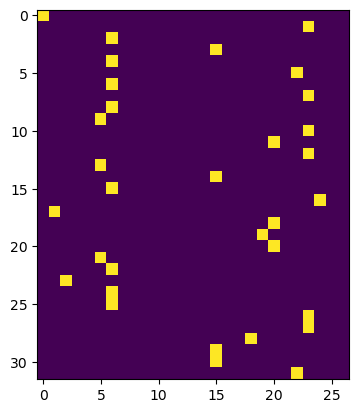

In [136]:
# Here we implement the derivative of each expression in the layers of the 2-layer MLP

# dlogprobs/dloss
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1.0/n    # d loss / d logprobs = that of a row in logprobs whose mean is taken to get loss.
compare('logprobs',dlogprobs,logprobs)

# dprobs/dlogprobs = d (log(probs))/dprobs = 1/probs
dprobs = 1.0/probs * dlogprobs # also multiply the derivative carries backwards (dlogprobs/dloss)
compare('probs',dprobs,probs)

# dcounts_sum_inv/dprobs = d (counts*counts_sum_inv)/dprobs = d (counts * counts_sum**-1)/dprobs 
# On a basic level, the following happens:
# logits = xenc@W
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
# Also, counts is (batch_size, vocab_size) and counts_sum_inv is (batch_size, 1) so there is an implicit broadcasting that pytorch does
# This means that before the multiplication, a copying of the cons_sum_inv across the vocab_size dimension happens, therefore,
# the probs operation is actually two separate operations.
# Let us first backprop through the multiplication
# dcounts_sum_inv = (counts * dprobs) # this is the derivative of the replication, which need to be summed over the vocab_size dimension
# to complete the operation
dcounts_sum_inv = (counts * dprobs).sum(1,keepdim=True) # this is the derivative of the sum
compare('counts_sum_inv',dcounts_sum_inv,counts_sum_inv)
# dcounts_sum
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv # this is the derivative of the square
compare('counts_sum',dcounts_sum,counts_sum)
# dcounts_sum/dcounts_sum_inv = 
dcounts = counts_sum_inv * dprobs 
# This needs better understanding with pen and paper, but as counts is used twice, the derivatives w.r.t separate functions need to be added
dcounts += torch.ones_like(counts) * dcounts_sum  # as dcounts was previously already added, we need to add this to the previous derivative
compare('counts',dcounts,counts)

# dcounts/dnorm_logits = d(exp(norm_logits))/dnorm_logits = exp(norm_logits)
dnorm_logits = norm_logits.exp() * dcounts
compare('norm_logits',dnorm_logits,norm_logits)

# norm_logits = logits - logits_maxes; 
# Can be written in an example form as the following:
# c11 c12 c13 = a11 a12 a13 - b1 
# c21 c22 c23 = a21 a22 a23 - b2
# c31 c32 c33 = a31 a32 a33 - b3
# therefore, c23 = a23 - b2  so d c23 / d a23 = 1 and d c23 / d b2 = -1; remember that b is implicitly broadcasted because it has a smaller dimension
# if dlogits is the a matrix and the dlogits_maxes is the b matrix, then the following is the derivative
dlogits = torch.ones_like(logits) * dnorm_logits # or dnorm_logits.clone()
dlogits_maxes = -dnorm_logits.sum(1,keepdim=True) # where summing is performed because of the implicit broadcasting
compare('logits_maxes',dlogits_maxes,logits_maxes)
compare('logits before logits_maxes is corrected',dlogits,logits) # This will be approximately true, but not quite exactly, because logits_maxes is itself a function of logits

# One point to note is that norm_logits = logits - logits_maxes, the subtraction is done to prevent overflow in the exp function, i.e., very high values
# norm_logits is making sure that the highest number that goes to the exp function is 0.
# Therefore dlogits_maxes will be in general very small numbers because changing logits maxes will not change probs much.

# logits_maxes = logits.max(1,keepdim=True).values
logits.max(1,keepdim=True) # This stores both the maxes and the indices of the maxes
# In the forward pass, the indices are not used. We only need the maxes.
# but in the backward pass, we need the indices to know which element of the logits to subtract from.
# Therefore the local derivative is 1 at the index the max was plucked out from and zero everywhere else.
# This can be done using the one_hot function
dlogits += F.one_hot((logits.max(1).indices),num_classes = logits.shape[1]) * dlogits_maxes 
# remember that dlogits_maxes is broadcasted into a shape the one_hot matrix can be multiplied with.
# This means the dlogits_maxes will be multiplied to all elements of the one_hot matrix, but since
# the place where the max does not exist is zero, the derivative will not be carried to that place.
# It will only be carried to the index which is 1, which corresponds to the max value.
# Now let us compare:
compare('logits after logits_maxes is corrected',dlogits,logits)
# visualizing the one hot function
plt.imshow(F.one_hot((logits.max(1).indices),num_classes = logits.shape[1])) 
# This shows where the max was plucked out from. The rest of the matrix is zero. This is exactly what we need
# because the one_hot is one at the needed site, given by the indices, and zero everywhere else.

# Now, logits = h @ W2 + b2
dlogits.shape, h.shape, W2.shape, (h@W2).shape,b2.shape 
# gives (32,27), (32,64), (64,27), (32,27),(27,), so the + operator for the b2 bias is broadcasted 32 times

# now let us take a small example to understand this logits calculation better
# d11 d12 = a11 a12   b11 b12    c1 c2
#                   *          +
# d21 d22 = a21 a22   b21 b22    c1 c2
# c corresponds to the broadcased b2, b1 is the W2 matrix and h is the a matrix
# This gives
# d11 = (a11 * b11) + (a12 * b21) + c1
# d12 = (a11 * b12) + (a12 * b22) + c2         # exp_1
# d21 = (a21 * b11) + (a22 * b21) + c1
# d22 = (a21 * b12) + (a22 * b22) + c2
# We have the derivative of the loss w.r.t. d, we need to know the derivative of the loss w.r.t. a, b and c
# dloss/dd = dloss/dd * dd/da * dd/db * dd/dc
# dloss/da11 = dloss/dd11 * b11 + dloss/dd12 * b12 (all others are zero because d21 and d22 do not have a11)
# Similarly,
# dloss/da12 = dloss/dd11 * b21 + dloss/dd12 * b22 (all others are zero because d21 and d22 do not have a12)
# dloss/da21 = dloss/dd21 * b11 + dloss/dd22 * b12 (all others are zero because d11 and d12 do not have a21)
# dloss/da22 = dloss/dd21 * b21 + dloss/dd22 * b22 (all others are zero because d11 and d12 do not have a22)
# Therefore:
# dloss/da = dloss/da11 dloss/da12
#            dloss/da21 dloss/da22
#       dloss/da11 dloss/da12           dloss/dd11 dloss/dd12   b11 b21
# =>                              =                           * 
#       dloss/da21 dloss/da22           dloss/dd21 dloss/dd22   b12 b22
# Note how the b matrix is now transposed. 
# Therefore, dloss/da = dloss/dd @ b.T

# dloss/db is tedious, but you could take the derivative of dloss/db and it should be something like:
# dloss/db = a.T @ dloss/dd 

# dloss/dc1 = dloss/dd11 * 1 + dloss/dd21 * 1
# dloss/dc2 = dloss/dd12 * 1 + dloss/dd22 * 1
# Therefore dloss/dc = dloss/dd summed over the columns
# dloss/dc = dloss/dd.sum(0)

# Therefore, the following is the derivative of the loss w.r.t. the logits
dh = dlogits @ W2.T # dloss/da = dloss/dd @ b.T
dW2 = h.T @ dlogits # dloss/db = a.T @ dloss/dd
db2 = dlogits.sum(0) # dloss/dc = dloss/dd.sum(0)
# perform the comparison
compare('h',dh,h)
compare('W2',dW2,W2)
compare('b2',db2,b2)
# It is interesting to note that in the micrograd, we did not transpose, we just exchanged the gradients
# However, when you have a matrix, the transpose is needed. This makes sense because otherwise,
# the matrix multiplication is wrongly sized. 

# dhpreact is needed, which is backpropagation through a tanh function
# remember that tanh derivation is as follows:
# if a = tanh(x), then da/dx = 1 - a^2 = 1 - tanh(x)^2
# therefore, dhpreact = dh * (1 - h^2)
dhpreact = dh * (1 - h**2)
compare('hpreact',dhpreact,hpreact)

# We need to backpropagate through the batchnorm layer:
# hpreact = bngain*bnraw + bnbias # hidden layer preactivation
# While this looks like logits = h @ W2 + b2,
# this isn't a matrix multiplication, rather it is an element wise multiplication.
# this you can observe by looking at the size of bngain and bnbias
hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape
# If you look at the shape differences, clearly bngain and bnbias are being broadcasted
# in order to multiply with bnraw.
dbngain = (dhpreact * bnraw).sum(0) # dloss/dbngain = dloss/dhpreact * [dhpreact/dbngain ; which is bnraw] (chain rule) 
# the summing is done because of the broadcasting, which means summing over the columns of (dhpreact * bnraw)
dbnbias = dhpreact.sum(0) # dloss/dbnbias = dloss/dhpreact * [dhpreact/dbnbias which is 1]; (chain rule) 
# the summing is done because of the broadcasting, which means summing over the columns of dhpreact
# Let us now compare with pytorch
compare('bngain',dbngain,bngain)
compare('bnbias',dbnbias,bnbias)
dbnbias.shape, dbngain.shape # these are the wrong shapes, we need to keep the dim
# rewriting the above
dbngain = (dhpreact * bnraw).sum(0,keepdim=True) # dloss/dbngain = dloss/dhpreact * [dhpreact/dbngain ; which is bnraw] (chain rule)
dbnbias = dhpreact.sum(0,keepdim=True) # dloss/dbnbias = dloss/dhpreact * [dhpreact/dbnbias which is 1]; (chain rule)
dbnbias.shape, dbngain.shape # these are the right shapes

# dbnraw is needed, which is backpropagation through the batchnorm layer
dbnraw = dhpreact * bngain # no broadcasting done here and therefore, there is no column wise addition
dbnraw.shape
# compare
compare('bnraw',dbnraw,bnraw)

# now, bnraw = bndiff * bnvarinv 
# so dloss/dbndiff = dloss/dbnraw * dbnraw/dbndiff 
# and dloss/dbnvar =  dloss/dbnraw * dbnraw/dbnvarinv
dbndiff = (dbnraw * bnvar_inv) # dloss/dbndiff = dloss/dbnraw * dbnraw/dbndiff
dbnvarinv = (dbnraw * bndiff).sum(0,keepdim=True) # dloss/dbnvar =  dloss/dbnraw * dbnraw/dbnvarinv, summing is to respect broadcasting
# compare
compare('bndiff before correction',dbndiff,bndiff) 
compare('bnvarinv',dbnvarinv,bnvar_inv)

# bndiff expected to be incorrect because bnvar_inv is a function of bnvar, which is a function of bndiff2, which is again a function of bndiff
# therefore, some additions are necessary for bndiff. We will leave them be for now and continue. When we encounter
# bndiff again we will simply += to the previous value. This should make the gradient correct.

# Continuing
# bnvar_inv = (bnvar + 1e-5)**-0.5 # inverse of the variance with 1e-5 to prevent division by zero
dbnvar = dbnvarinv * (-0.5 * (bnvar + 1e-5)**-1.5)
compare('bnvar',dbnvar,bnvar)

# bnvar = (1/(n-1)) * bnsqdiff.sum(0,keepdim=True) # variance
# because there is summing, the derivative is (1/(n-1))
dbnsqdiff = (dbnvar * (1/(n-1))*torch.ones_like(bnsqdiff)) # dloss/dbsqndiff = dloss/dbnvar * dbnvar/dbnsqdiff
compare('bnsqdiff',dbnsqdiff,bnsqdiff)

# bnsqdiff = bndiff**2 # square of the difference
dbndiff += dbnsqdiff * (2 * bndiff) # dloss/dbndiff = dloss/dbnsqdiff * dbnsqdiff/dbndiff
compare('bndiff after correction',dbndiff,bndiff) # now it should be correct


# bndiff = hprebn-bnmeani # difference of the hidden layer preactivation from the mean
bndiff.shape, bnmeani.shape, hprebn.shape
# The above give (32,64) (1,64) (32,64) which means that bnmeani is being broadcasted for the minus sign
# Broadcasting means variable reuse, which means a sum in the backward pass.
dhprebn = dbndiff # dloss/dhprebn = dloss/dbndiff * dbndiff/dhprebn = dloss/dbndiff * 1
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0,keepdim=True)   # dloss/dbnmeani = dloss/dbndiff * dbndiff/dbnmeani = dloss/dbndiff * -1, the summing is to allow broadcasting
compare('bnmeani',dbnmeani,bnmeani)
compare('hprebn before correction',dhprebn,hprebn) 

# dhprebn is calculated wrongly as we are bnmeani is a function of hprebn
# therefore, we need to add the derivative of bnmeani with respect to hprebn

# bnmeani = 1/n*hprebn.sum(0,keepdim=True) # mean of the hidden layer preactivation
dhprebn += torch.ones_like(hprebn)*(dbnmeani * (1.0/n)) # dloss/dhprebn = dloss/dbnmeani * dbnmeani/dhprebn = dloss/dbnmeani * 1/n
# torch.ones_like is used here because of the broadcasting
compare('hprebn after correction',dhprebn,hprebn) 

# now hprebn = Xb_concat @ W1 + b1 
# so going by our previous treatment of the linear layer
dXb_concat = dhprebn @ W1.T # dloss/dXb_concat = dloss/dhprebn * dhprebn/dXb_concat = dloss/dhprebn * W1.T
dW1 = Xb_concat.T @ dhprebn # dloss/dW1 = dloss/dhprebn * dhprebn/dW1 = dloss/dhprebn * Xb_concat.T
db1 = dhprebn.sum(0,keepdim=True) # dloss/db1 = dloss/dhprebn * dhprebn/db1 = dloss/dhprebn * 1, summing is to allow broadcasting
compare('Xb_concat',dXb_concat,Xb_concat)
compare('W1',dW1,W1)
compare('b1',db1,b1)


# Xb_concat = Xb_embed.view(Xb_embed.shape[0],-1)
# Xb_concat is a concatenated version of Xb_embed
# Therefore we have to undo the concatenation for the backward pass
dXb_embed= dXb_concat.view(Xb_embed.shape)
compare('Xb_embed',dXb_embed,Xb_embed)

# Xb_embed = C[Xb] # convert the input to embeddings
# This operation just pulls out the rows of the embedding matrix, 
# which means we need a one-hot encoding to route the gradient to the right place
# This cannot be done in a more efficient way besides using for-loops
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += dXb_embed[k,j] # addition because you may find the same index multiple times
compare('C',dC,C)




Comparing logits          | Exact False | Approx True  | Max Diff 4.423782229423523e-09


tensor(6.9849e-10, grad_fn=<SumBackward0>)

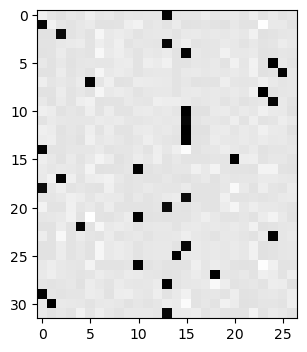

In [142]:
# While instructive, the above backpropagation is not very efficient.
# all of the expressions had to be unpacked to make it manageble to understand.

# dlogits can be calculated much more simply if one looks at the full expression
# on pen and paper. Not doing it here.

dlogits = F.softmax(logits, 1) # apply logits to the rows of logits
dlogits[range(n),Yb] -= 1 # subtract 1 from the correct class
dlogits /= n # divide by the number of samples
compare('logits',dlogits,logits)
# You do not get an exact match, but the difference is very small.
# This is due to floating point wonkiness.
plt.figure(figsize=(4,4))
plt.imshow(dlogits.detach(),cmap='gray')

# in a forward pass, logits is the probability matrix
# If you see the plot below, the black square are the correct classes where we 
# subtracted 1, which means they are zero, exp(0) is 1, and the softmax is 1, i.e., the correct class
# take for example 
F.softmax(logits,1)[0] # the first row of logits
# and look at the backward pass
dlogits[0]*n # the first row of dlogits
# it is -1 in one spot and above zero on the others
# Furthermore, the sum of this is very small
(dlogits[0]).sum()
# Therefore, the gradients at each cell of dlogits
# tries to pull down the probability of the incorrect characters/class
# while it tries to pull up the probability of the correct character/class
# The amount of push and pull is equalized, as their row sum is zero.

# What that means is that currently in the forward pass the prediction is wrong
# therefore dlogits is set to negative of the position at that predicted character
# and is trying to move the network away from that prediction. They are shown as black in the 
# plot because they are negative, and the implot cannot show negative values.

# Therefore, one can consider the nn as a pulley system which tries to pull the correct class up
# and the incorrect classes down, while keeping the forces balanced.

In [144]:
# we will now also try to glue the batchnorm expressions together for faster forward pass

hpreact_fast = bngain * (hprebn - hprebn.mean(0,keepdim=True)) / torch.sqrt(hprebn.var(0,keepdim=True,unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [147]:
# Let us now try to implement a fast backward pass using the derivative of the fused expression
# which offers the same benefits of cancelling of terms as seen with dlogits (fast version)

dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
compare('hprebn fast version',dhprebn,hprebn)

# Not exactly the same but the difference is very small due to floating point wonkiness.


Comparing hprebn fast version | Exact False | Approx True  | Max Diff 5.587935447692871e-09


In [61]:
# putting it all together

# Build and initialize a two layer MLP

from tqdm import trange

n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # use the same as Karpathy's
C = torch.randn((vocab_size,n_embed)                ,generator=g) # embedding matrix that converts words to embeddings
# Layer 1
W1 = torch.randn((n_embed*block_size,n_hidden)      ,generator=g) * (5/3)/((n_embed * block_size)**0.5) # initialize with reasonable weights
b1 = torch.randn((n_hidden,)                        ,generator=g) * 0.1 # initialize with reasonable weights
# Layer 2
W2 = torch.randn((n_hidden,vocab_size)              ,generator=g) * 0.1 # initialize with reasonable weights
b2 = torch.randn((vocab_size,)                      ,generator=g) * 0.1 # initialize with reasonable weights
# Batchnorm between Layer 1 and Layer 2. This is why the weights of Layer 2 are initialized with 0.1 and not (5/3)/n_elem**0.5
bngain = torch.randn((1,n_hidden)) * 0.1 +1.0 # initialize with reasonable weights and add 1 to make it non-zero
bnbias = torch.randn((1,n_hidden)) * 0.1 # initialize with reasonable weights

# According to Karpathy, the initialization multiples are non standard to avoid zero initialization
# from masking any implementation errors.

# concatenate all the above parameters to a parameter vector
parameters = [C,W1,b1,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# optimizer params
max_steps = 200000
batch_size = 32
n = batch_size  
lossi = [] # intermediate loss for plotting
with torch.no_grad(): # we do not need to track gradients for the optimizer as we have our own implementation
    for i in range(max_steps):
    #for i in trange(max_steps, desc="Training", unit="it"):

        # mini batch construction
        ix = torch.randint(0,X_train.shape[0],(batch_size,),generator=g)
        Xb ,Yb = X_train[ix],Y_train[ix]
        
        
        # Forward passing through the network
        # Embedding layer
        emb = C[Xb] # convert the input to embeddings
        # concatenate the embeddings
        embcat = emb.view(emb.shape[0],-1)
        # Linear Layer 1
        hprebn = embcat @ W1 + b1 # hidden layer preactivation
        # Batchnorm
        bnmean = hprebn.mean(0,keepdim=True) # mean of the hidden layer preactivation
        bnvar = hprebn.var(0,keepdim=True,unbiased=True) # variance of the hidden layer preactivation
        # Layer norm (do not update bnmean and bnvar as the averaging is not performed over the batches now)
        #bnmean = hprebn.mean(1,keepdim=True) # mean of the hidden layer preactivation
        #bnvar = hprebn.var(1,keepdim=True,unbiased=True) # variance of the hidden layer preactivation
        bnvar_inv = (bnvar + 1e-5)**-0.5 # inverse of the variance with 1e-5 to prevent division by zero
        bnraw = (hprebn - bnmean) * bnvar_inv # raw output of the batchnorm
        hpreact = bngain * bnraw + bnbias
        
        # Non-linearity
        h = torch.tanh(hpreact)
        # Linear Layer 2
        logits = h @ W2 + b2 # logits
        # Cross entropy loss
        loss = F.cross_entropy(logits,Yb) # cross entropy loss

        # backward pass

        # Pytorch backward pass
        for p in parameters:
            p.grad = None
        #loss.backward()

        # Your own backward pass:
        # cross entropy backward pass
        dlogits = F.softmax(logits, 1) # apply logits to the rows of logits
        dlogits[range(n),Yb] -= 1 # subtract 1 from the correct class
        dlogits /= n # divide by the number of samples
        
        
        
        # Linear Layer 2 backward pass
        dh = dlogits @ W2.T # dloss/da = dloss/dd @ b.T
        dW2 = h.T @ dlogits # dloss/db = a.T @ dloss/dd
        db2 = dlogits.sum(0) # dloss/dc = dloss/dd.sum(0)
        # Non-linearity backward pass
        dhpreact = (1.0 - h**2) * dh 
       
        # Batchnorm backward pass
        dbngain = (bnraw * dhpreact).sum(0,keepdim=True) # dloss/dbngain = dloss/dhpreact * [dhpreact/dbngain ; which is bnraw] (chain rule) 
        dbnbias = dhpreact.sum(0,keepdim=True) # dloss/dbnbias = dloss/dhpreact * [dhpreact/dbnbias ; which is 1] (chain rule)
        dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
        
        
        # Linear Layer 1 backward pass
        dembcat = dhprebn @ W1.T # dloss/dXb_concat = dloss/dhprebn * dhprebn/dXb_concat = dloss/dhprebn * W1.T
        dW1 = embcat.T @ dhprebn # dloss/dW1 = dloss/dhprebn * dhprebn/dW1 = dloss/dhprebn * Xb_concat.T
        db1 = dhprebn.sum(0) # dloss/db1 = dloss/dhprebn * dhprebn/db1 = dloss/dhprebn * 1, summing is to allow broadcasting
        
        
        # Embedding backward pass
        demb= dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix] += demb[k,j] # addition because you may find the same index multiple times
        

        # Collect all the grads
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias] 
        
        # update the parameters
        lr = 0.1 if i<100000 else 0.01
        # Own method
        for p,grad in zip(parameters,grads):
            p.data += -lr * grad
        
        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
            #print(f'training loss: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
        
plt.plot(lossi)

12297
      0/ 200000: 3.5426
  10000/ 200000: 2.4924
  20000/ 200000: 2.3489
  30000/ 200000: 2.5809
  40000/ 200000: 2.0048
  50000/ 200000: 2.0849
  60000/ 200000: 2.4541
  70000/ 200000: 2.2546
  80000/ 200000: 1.8467
  90000/ 200000: 2.1783


In [52]:
# calibrate the batch norm at the end of training (avoid if layer norm is used)

with torch.no_grad():
  # pass the training set through
  emb = C[X_train]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [53]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0687193870544434
val 2.116607666015625


In [54]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(idx2char[i] for i in out))

carmah.
ambrie.
khi.
mili.
taty.
salani.
emmahnee.
delynn.
jareen.
ner.
kiah.
maiivon.
leigh.
ham.
prin.
quint.
shon.
walianni.
waython.
jaryn.
